In [162]:
#Importing all the libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import timeit
%timeit
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import Imputer



In [163]:
# Load the CSV file to a Pandas Dataframe

df=pd.read_csv("movie_metadata.csv")


In [164]:
#Max length of the dataframe

len(df)


5043

In [165]:
#Display the columns. Total 28 Columns.

df.columns


Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')

In [166]:
#column counts substracting from total length. If different, means missing data.

len(df)- df.count()

#So no missing data for genres, movie_title, num_voted_users, cast_total_facebook_likes, movie_imdb_link,
#imdb_score, movie_facebook_likes

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [167]:
#Applying Describe method to understand all statistical values for all the numeric fields.

df['imdb_score'].describe()

#imdb_score has max value of 9.5 and minimum value of 1.6 out of 10 for all the movies in the dataframe with a 
#mean of 6.44 having standard deviation of 1.125.

count    5043.000000
mean        6.442138
std         1.125116
min         1.600000
25%         5.800000
50%         6.600000
75%         7.200000
max         9.500000
Name: imdb_score, dtype: float64

In [168]:
#Applying Describe method to understand all statistical values for all the numeric fields.

df.describe()



,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,4993.000000,5028.000000,4939.000000,5020.000000,5036.000000,4.159000e+03,5.043000e+03,5043.000000,5030.000000,5022.000000,4.551000e+03,4935.000000,5030.000000,5043.000000,4714.000000,5043.000000
mean,140.194272,107.201074,686.509212,645.009761,6560.047061,4.846841e+07,8.366816e+04,9699.063851,1.371173,272.770808,3.975262e+07,2002.470517,1651.754473,6.442138,2.220403,7525.964505
std,121.601675,25.197441,2813.328607,1665.041728,15020.759120,6.845299e+07,1.384853e+05,18163.799124,2.013576,377.982886,2.061149e+08,12.474599,4042.438863,1.125116,1.385113,19320.445110
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,0.000000,1.000000,2.180000e+02,1916.000000,0.000000,1.600000,1.180000,0.000000
25%,50.000000,93.000000,7.000000,133.000000,614.000000,5.340988e+06,8.593500e+03,1411.000000,0.000000,65.000000,6.000000e+06,1999.000000,281.000000,5.800000,1.850000,0.000000
50%,110.000000,103.000000,49.000000,371.500000,988.000000,2.551750e+07,3.435900e+04,3090.000000,1.000000,156.000000,2.000000e+07,2005.000000,595.000000,6.600000,2.350000,166.000000
75%,195.000000,118.000000,194.500000,636.000000,11000.000000,6.230944e+07,9.630900e+04,13756.500000,2.000000,326.000000,4.500000e+07,2011.000000,918.000000,7.200000,2.350000,3000.000000
max,813.000000,511.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.689764e+06,656730.000000,43.000000,5060.000000,1.221550e+10,2016.000000,137000.000000,9.500000,16.000000,349000.000000


In [169]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

(array([   2.,    3.,    2.,    6.,    3.,    4.,    8.,    9.,    9.,
           8.,   24.,   12.,   29.,   23.,   14.,   44.,   20.,   56.,
          71.,   31.,  104.,   42.,  139.,   92.,  202.,  229.,  124.,
         275.,  179.,  351.,  185.,  387.,  404.,  174.,  365.,  195.,
         331.,  264.,  114.,  181.,   75.,  111.,   40.,   53.,   28.,
           7.,    8.,    3.,    2.,    1.]),
 array([ 1.6  ,  1.758,  1.916,  2.074,  2.232,  2.39 ,  2.548,  2.706,
         2.864,  3.022,  3.18 ,  3.338,  3.496,  3.654,  3.812,  3.97 ,
         4.128,  4.286,  4.444,  4.602,  4.76 ,  4.918,  5.076,  5.234,
         5.392,  5.55 ,  5.708,  5.866,  6.024,  6.182,  6.34 ,  6.498,
         6.656,  6.814,  6.972,  7.13 ,  7.288,  7.446,  7.604,  7.762,
         7.92 ,  8.078,  8.236,  8.394,  8.552,  8.71 ,  8.868,  9.026,
         9.184,  9.342,  9.5  ]),
 <a list of 50 Patch objects>)

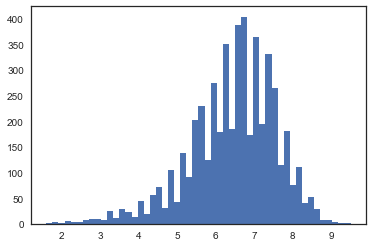

In [170]:
#Histogram of IMDB Movie Score

plt.hist(df.imdb_score.dropna(),bins=50)

#df['imdb_score'].plot(kind='hist', title='HISTOGRAM OF IMDB MOVIE SCORE(1-10)',bins=150)


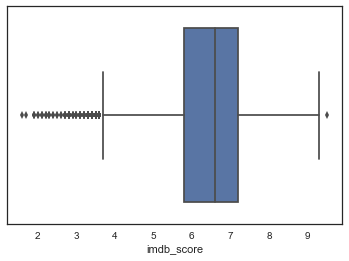

In [171]:
#boxplot of IMDB_SCORE
sns.boxplot(df.imdb_score.dropna())

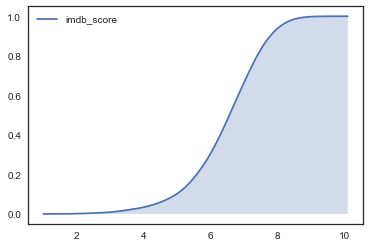

In [172]:
#Kernel Density Estimate Plot for IMDB_SCORE
sns.kdeplot(df.imdb_score,shade=True,cumulative=True)

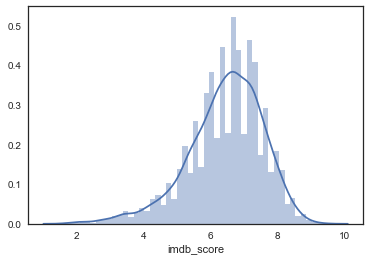

In [173]:
sns.distplot(df.imdb_score)

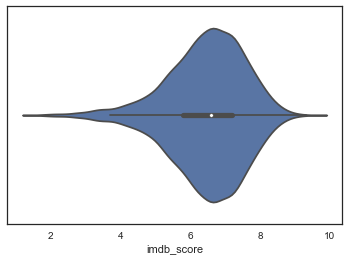

In [174]:
#violinplot

sns.violinplot(df.imdb_score)

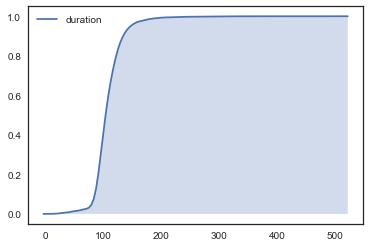

In [175]:
#KDE of duration

sns.kdeplot(df.duration.dropna(),cumulative=True,shade=True)


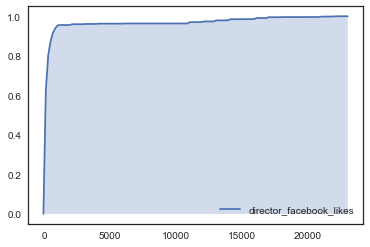

In [176]:
#KDE OF director_facebook_likes

sns.kdeplot(df.director_facebook_likes.dropna(),cumulative=True,shade=True)

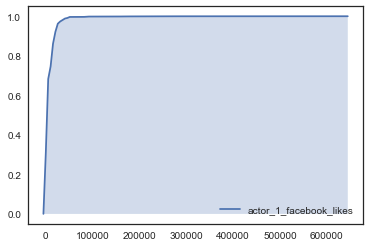

In [177]:
#KDE OF actor_1_facebook_likes

sns.kdeplot(df.actor_1_facebook_likes.dropna(),cumulative=True,shade=True)

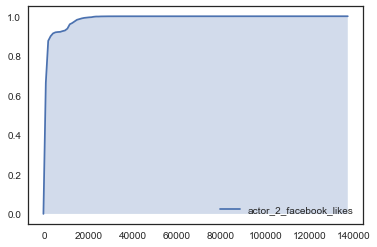

In [178]:
#KDE OF actor_2_facebook_likes

sns.kdeplot(df.actor_2_facebook_likes.dropna(),cumulative=True,shade=True)

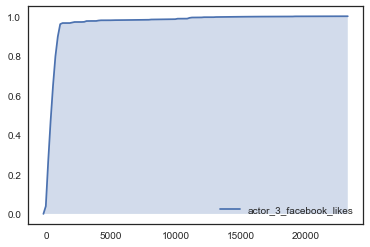

In [179]:
#KDE OF actor_3_facebook_likes

sns.kdeplot(df.actor_3_facebook_likes.dropna(),cumulative=True,shade=True)

C:\Users\Amrita\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


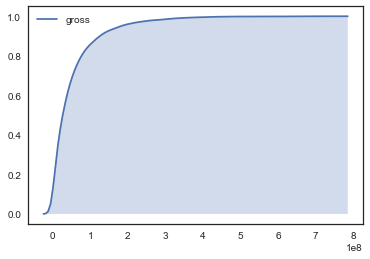

In [180]:
#KDE OF gross VS Budget

sns.kdeplot(df.gross.dropna(),cumulative=True,shade=True)
#sns.kdeplot(df.budget.dropna(),cumulative=True,shade=True)

In [181]:
# IMDB SCORE will be my pridected output variable. Float Variable.

# Check to see if imdb_score field is having any missing values or not.

df[df['imdb_score'] < 1]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes


In [182]:
df[df['imdb_score'] < 0]

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes


In [183]:
len(df[df['imdb_score'].notnull()])

5043

In [184]:
len(df[df['imdb_score'].isnull()])


0

In [185]:
len(df)- df.count()

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

In [186]:
# Define Function which will determine missing value percentages for any Data Fields

def missval_chk(data):
    missval_cnt = len(df)- df.count()
    isnull_count = len(df[df[data].isnull()])
    if len(df)> 0:
        percent = ((missval_cnt[data]/len(df)) * 100)
    else:
        percent = 0.0
    return isnull_count, percent

def function(*args):
    for arg in args:
        print("Missing value count,percent for " + arg + " col: " + str(missval_chk(arg)))
       

In [187]:
function('duration','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
             'director_facebook_likes','imdb_score')

Missing value count,percent for duration col: (15, 0.29744199881023198)
Missing value count,percent for actor_1_facebook_likes col: (7, 0.13880626611144162)
Missing value count,percent for actor_2_facebook_likes col: (13, 0.25778306563553438)
Missing value count,percent for actor_3_facebook_likes col: (23, 0.45607773150902242)
Missing value count,percent for director_facebook_likes col: (104, 2.062264525084275)
Missing value count,percent for imdb_score col: (0, 0.0)


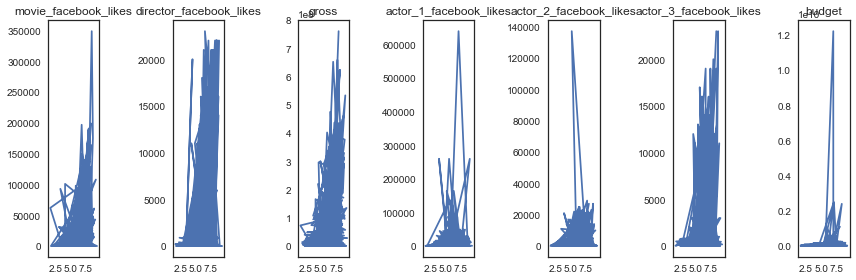

In [188]:

fig, axes = plt.subplots(1, 7, figsize=(12, 4))

axes[0].plot(df['imdb_score'], df['movie_facebook_likes'])
axes[0].set_title("movie_facebook_likes")

axes[1].plot(df['imdb_score'], df['director_facebook_likes'])
axes[1].axis('tight')
axes[1].set_title("director_facebook_likes")

axes[2].plot(df['imdb_score'], df['gross'])
axes[2].set_title("gross")

axes[3].plot(df['imdb_score'], df['actor_1_facebook_likes'])
axes[3].set_title("actor_1_facebook_likes")

axes[4].plot(df['imdb_score'], df['actor_2_facebook_likes'])
axes[4].axis('tight')
axes[4].set_title("actor_2_facebook_likes")

axes[5].plot(df['imdb_score'], df['actor_3_facebook_likes'])
axes[5].set_title("actor_3_facebook_likes")

axes[6].plot(df['imdb_score'], df['budget'])
axes[6].set_title("budget")

plt.tight_layout()

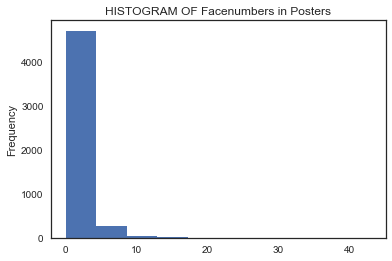

In [189]:
#Histogram of facenumber_in_poster

df['facenumber_in_poster'].plot(kind='hist', title='HISTOGRAM OF Facenumbers in Posters')

#nearly 95% of all the 4096 posters have less than 5 faces.

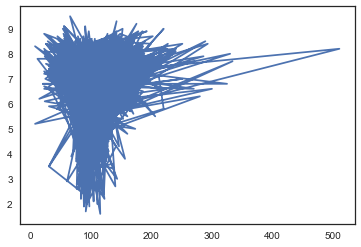

In [190]:
plt.plot(df['duration'], df['imdb_score'])

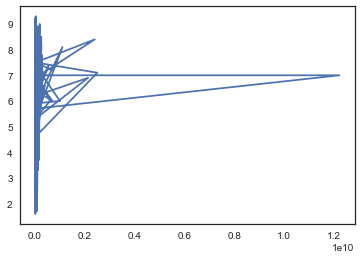

In [191]:
plt.plot(df['budget'], df['imdb_score'] )

# check % of total # of rows we'll have to drop across all 4 cols

In [192]:
# My output column is imdb_score.
# No missing values for imdb_score, so no rows dropping for this. Total rows are 5043.

In [193]:
#My three choosen input columns are
#director_facebook_likes(104 rows)
#actor_1/2/3_facebook_likes(Total 43 rows)
#duration(15 rows)

In [194]:
#Dataframe copied to a new one for dropping/manipulation purpose.
df_copy= df.copy()

In [195]:
# Writing a function which will determine % of rows dropped for these input and output variables selected.

def droprows_det(arg1,arg2,arg3,arg4,arg5,arg6):
    
        counter=len(df_copy) 
        print("Total Number of rows for the dataframe: " + str(counter))
        #print("Missing value count,percent for duration col: " + str(missval_chk('duration'))
    
        df_copy1= df_copy[df_copy[arg1].notnull()]  
        percent1= ((counter - len(df_copy1))/ counter)*100
        counter1=len(df_copy1) 
        print("% of rows(" + str(counter-counter1)+ ") dropped for " + arg1 + " column " + " is : " + str(percent1))
        print("New dataframe size is: "  + str(counter1))
        
        df_copy2= df_copy1[df_copy1[arg2].notnull()]
        percent2= ((counter1 - len(df_copy2))/ counter1)*100
        counter2=len(df_copy2)
        print("% of rows(" + str(counter1-counter2)+ ") dropped for " + arg2 + " column " + " is : " + str(percent2))
        print("New dataframe size is: "  + str(counter2))
        
                
        df_copy3= df_copy2[df_copy2[arg3].notnull()] 
        percent3= ((counter2 - len(df_copy3))/ counter2)*100
        counter3=len(df_copy3)
        print("% of rows(" + str(counter2-counter3)+ ") dropped for " + arg3 + " column " + " is : " + str(percent3))
        print("New dataframe size is: "  + str(counter3))
                
        df_copy4= df_copy3[df_copy3[arg4].notnull()] 
        percent4= ((counter3 - len(df_copy4))/ counter3)*100
        counter4=len(df_copy4)
        print("% of rows(" + str(counter3-counter4)+ ") dropped for " + arg4 + " column " + " is : " + str(percent4))
        print("New dataframe size is: "  + str(counter4))
                
        df_copy5= df_copy4[df_copy4[arg5].notnull()] 
        percent5= ((counter4 - len(df_copy5))/ counter4)*100
        counter5=len(df_copy5)
        print("% of rows(" + str(counter4-counter5)+ ") dropped for " + arg5 + " column " + " is : " + str(percent5))
        print("New dataframe size is: "  + str(counter5))
        
        df_copy6= df_copy5[df_copy5[arg6].notnull()] 
        percent6= ((counter5 - len(df_copy5))/ counter5)*100
        counter6=len(df_copy6)
        print("% of rows(" + str(counter5-counter6)+ ") dropped for " + arg6 + " column " + " is : " + str(percent6))
        print("New dataframe size is: "  + str(counter6))
        

In [196]:
droprows_det('duration','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
             'director_facebook_likes','imdb_score')

Total Number of rows for the dataframe: 5043
% of rows(15) dropped for duration column  is : 0.297441998810232
New dataframe size is: 5028
% of rows(7) dropped for actor_1_facebook_likes column  is : 0.13922036595067622
New dataframe size is: 5021
% of rows(6) dropped for actor_2_facebook_likes column  is : 0.11949810794662419
New dataframe size is: 5015
% of rows(8) dropped for actor_3_facebook_likes column  is : 0.15952143569292124
New dataframe size is: 5007
% of rows(99) dropped for director_facebook_likes column  is : 1.9772318753744758
New dataframe size is: 4908
% of rows(0) dropped for imdb_score column  is : 0.0
New dataframe size is: 4908


In [197]:
print(len(df_copy))
df_copy= df_copy[df_copy['duration'].notnull()] 
print(len(df_copy))
df_copy=df_copy[df_copy['actor_1_facebook_likes'].notnull()] 
print(len(df_copy))
df_copy=df_copy[df_copy['actor_2_facebook_likes'].notnull()] 
print(len(df_copy))
df_copy=df_copy[df_copy['actor_3_facebook_likes'].notnull()] 
print(len(df_copy))
df_copy=df_copy[df_copy['director_facebook_likes'].notnull()] 
print(len(df_copy))
df_copy=df_copy[df_copy['imdb_score'].notnull()] 
print(len(df_copy))

5043
5028
5021
5015
5007
4908
4908


In [198]:
(df_copy)
        

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,263700000.0,2012.0,632.0,6.6,2.35,24000
6,Color,Sam Raimi,392.0,156.0,0.0,4000.0,James Franco,24000.0,336530303.0,Action|Adventure|Romance,...,1902.0,English,USA,PG-13,258000000.0,2007.0,11000.0,6.2,2.35,0
7,Color,Nathan Greno,324.0,100.0,15.0,284.0,Donna Murphy,799.0,200807262.0,Adventure|Animation|Comedy|Family|Fantasy|Musi...,...,387.0,English,USA,PG,260000000.0,2010.0,553.0,7.8,1.85,29000
8,Color,Joss Whedon,635.0,141.0,0.0,19000.0,Robert Downey Jr.,26000.0,458991599.0,Action|Adventure|Sci-Fi,...,1117.0,English,USA,PG-13,250000000.0,2015.0,21000.0,7.5,2.35,118000
9,Color,David Yates,375.0,153.0,282.0,10000.0,Daniel Radcliffe,25000.0,301956980.0,Adventure|Family|Fantasy|Mystery,...,973.0,English,UK,PG,250000000.0,2009.0,11000.0,7.5,2.35,10000
10,Color,Zack Snyder,673.0,183.0,0.0,2000.0,Lauren Cohan,15000.0,330249062.0,Action|Adventure|Sci-Fi,...,3018.0,English,USA,PG-13,250000000.0,2016.0,4000.0,6.9,2.35,197000


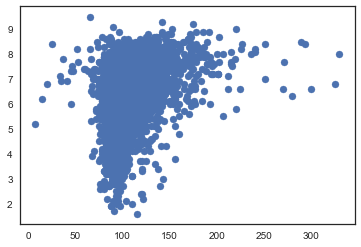

In [199]:
plt.scatter(df_copy['duration'], df_copy['imdb_score'] )

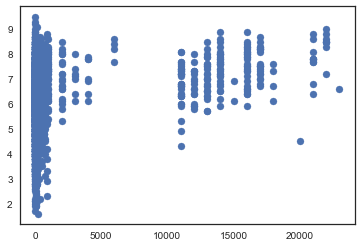

In [200]:
plt.scatter(df_copy['director_facebook_likes'], df_copy['imdb_score'] )

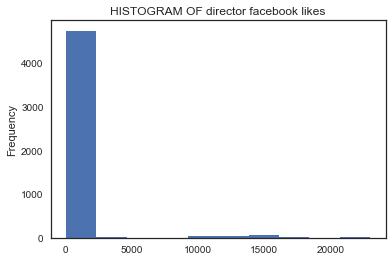

In [201]:
df['director_facebook_likes'].plot(kind='hist', title='HISTOGRAM OF director facebook likes')

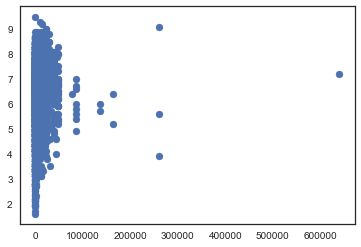

In [202]:
plt.scatter(df_copy['actor_1_facebook_likes'], df_copy['imdb_score'] )

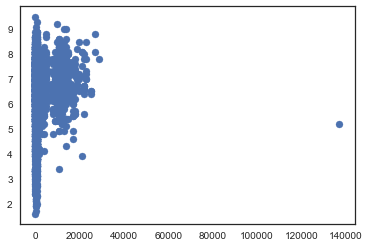

In [203]:
plt.scatter(df_copy['actor_2_facebook_likes'], df_copy['imdb_score'] )


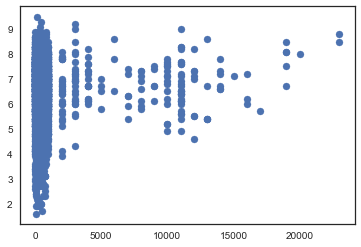

In [204]:
plt.scatter(df_copy['actor_3_facebook_likes'], df_copy['imdb_score'] )

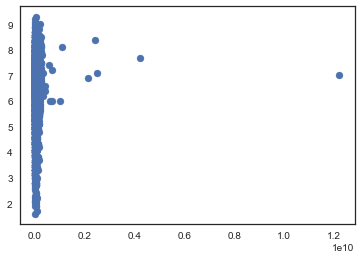

In [205]:
plt.scatter(df_copy['budget'], df_copy['imdb_score'] )

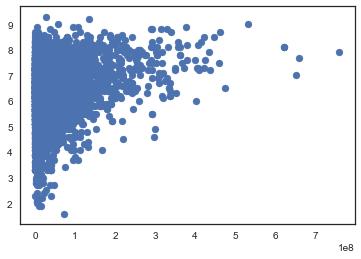

In [206]:
plt.scatter(df_copy['gross'], df_copy['imdb_score'] )

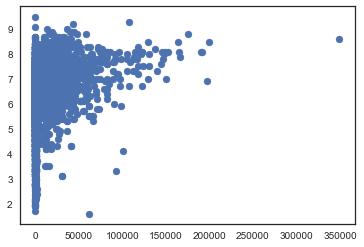

In [207]:
plt.scatter(df_copy['movie_facebook_likes'], df_copy['imdb_score'] )

In [208]:
# Adding actor_1_facebook_likes, actor_2_facebook_likes & actor_3_facebook_likes together and creating one new column 
#actor_facebook_likes_sum.

actor = (df_copy.actor_1_facebook_likes + df_copy.actor_2_facebook_likes + df_copy.actor_3_facebook_likes)

In [209]:
df_copy['actor_facebook_likes_sum'] = actor

In [210]:
#Creating one new dataframe df_lm having only my input independent and dependent output variables.

df_lm=df_copy[['director_facebook_likes','actor_facebook_likes_sum','duration','imdb_score']].copy()

In [211]:
df_lm.sort_values('imdb_score',ascending=False).head()

,director_facebook_likes,actor_facebook_likes_sum,duration,imdb_score
2765,0.0,1125.0,65.0,9.5
1937,0.0,12206.0,142.0,9.3
3466,0.0,27000.0,175.0,9.2
4409,134.0,260808.0,90.0,9.1
2837,0.0,39000.0,220.0,9.0


In [212]:
# split into a training and testing set. Selecting 30% for testing the Linear regression Model.

y = df_lm['imdb_score']

X = df_lm[['director_facebook_likes','actor_facebook_likes_sum','duration']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=110)


In [213]:
#Selecting 1473 records for model testing and 3435 records for training the model.

{'X_train_rows': len(X_train), 'y_train_rows': len(y_train), 'X_test_rows': len(X_test), 'y_test_rows': len(y_test)}


{'X_test_rows': 1473,
 'X_train_rows': 3435,
 'y_test_rows': 1473,
 'y_train_rows': 3435}

In [214]:
#Developing Liear Regression Model to predict IMDB_Score.


# Create linear regression object
regr = linear_model.LinearRegression()

# Start the Time to track the model training time
#start_time = timeit.default_timer()

# Train the model using the training sets
%timeit regr.fit(X_train, y_train)

#Printing the Model Train Time
#print("Training the Model time: " + str(timeit.default_timer() - start_time))

#start_time = timeit.default_timer()

#Predicting the target variable from test.
y_pred = regr.predict(X_test)

#Printing the Model output predit Time based on test data.
#print("Predicting time: " + str(timeit.default_timer() - start_time))

# The coefficients
print('Coefficients: \n', regr.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((y_pred - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))





100 loops, best of 3: 2.58 ms per loop
Coefficients: 
 [  4.57589045e-05   3.61228110e-06   1.51850886e-02]
Mean squared error: 1.09
Variance score: 0.14


([], <a list of 0 Text yticklabel objects>)

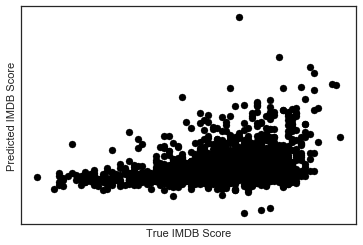

In [215]:
# Plot outputs
plt.scatter(y_test, y_pred,  color='black')
plt.xlabel('True IMDB Score')
plt.ylabel('Predicted IMDB Score')
#plt.plot(X_test, y_pred, color='blue',
#         linewidth=3)

plt.xticks(())
plt.yticks(())

# Evaluating the Model
Lets evaluate our model performance by calculating the residual sum of squares and explained variance score(R^2).

Calculate the Mean Absolute error, Mean squared error and the Root mean squared error.

In [216]:
print('MAE:  %.2f' %metrics.mean_absolute_error(y_test, y_pred))
print('MSE:  %.2f' %metrics.mean_squared_error(y_test, y_pred))
print('RMSE: %.2f' %np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE:  0.81
MSE:  1.09
RMSE: 1.05


In [217]:
print('EVS: %.2f' %metrics.explained_variance_score(y_test, y_pred))

EVS: 0.14


# Residuals

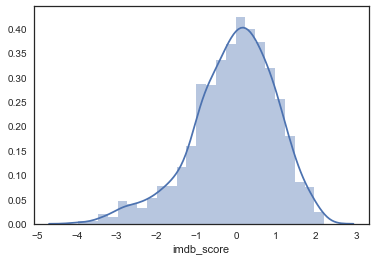

In [218]:
sns.distplot(y_test-y_pred, bins=25)

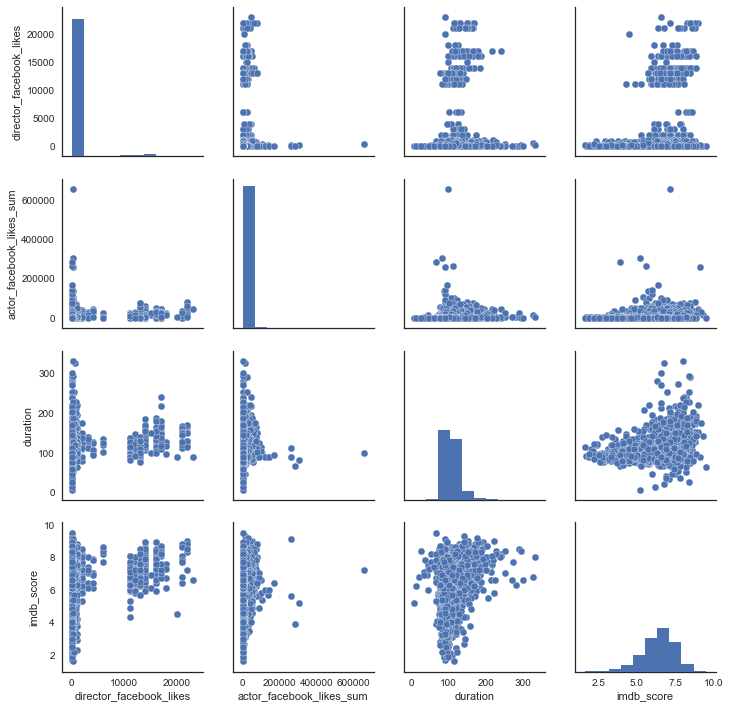

In [219]:
sns.pairplot(df_lm)

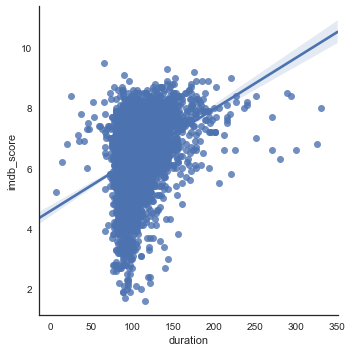

In [220]:
sns.lmplot(x='duration',y='imdb_score',data=df_lm)

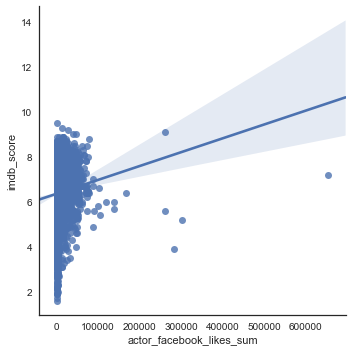

In [221]:
sns.lmplot(x='actor_facebook_likes_sum',y='imdb_score',data=df_lm)

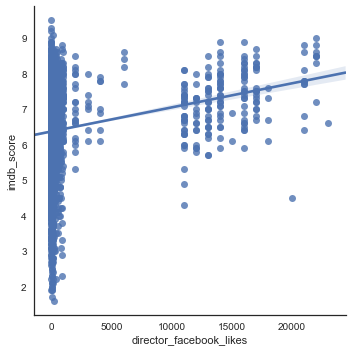

In [222]:
sns.lmplot(x='director_facebook_likes',y='imdb_score',data=df_lm)

Iteration 1 outcomes: My Linear Regression Iteration 1 gives me low score of 14% having 3 input independent variables director_facebook_likes, actor_facebook_likes_sum(actor 1 + actor 2 + actor 3 facebook likes) and duration selected to predict imdb_score. co-efficient values are small too [  4.57589045e-05   3.61228110e-06   1.51850886e-02]. I choose these variables as i see trends between these input variables and output variable.

Selected 3 input variables are not correctly linearly related with imdb_score causing low score. I will look for more input variables to improve my Linear Regression Model Score.

For iteration 2, i would like to choose more input variables(10 atleast) including categorical variables this time and run linear regression model to predict good score.


# Iteration 2

In [223]:
df_iter2 = df.copy()

In [224]:
# Taking care of missing data
#imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
#imputer = imputer.fit(df_iter2)
#df_itrer2 = imputer.transform(df_iter2)

#Dropping all missing value rows for any fields.
df_iter2 = df_iter2.dropna(axis=0,how='any')  #dropping all missing values.
df_it1 = df_iter2.iloc[:,0:25]                #selecting first 25 columns
df_it2 = df_iter2.iloc[:,26:28]               #selecting last two columns

X = pd.concat([df_it1, df_it2], axis=1).values #all fields except imdb_score 
y = df_iter2.iloc[:,25:26].values              #imdb_score


In [225]:
len(df_iter2)

3756

In [226]:
# Encoding categorical data
# Encoding the Independent Variables

labelencoder = LabelEncoder()

X[:, 0]  = labelencoder.fit_transform(X[:, 0])    #labelending of 'color'.
X[:, 1]  = labelencoder.fit_transform(X[:, 1])    #labelencoding of 'Director Names'.
X[:, 20] = labelencoder.fit_transform(X[:, 20])   #labelencoding of 'country'.

X[:, 6]  = labelencoder.fit_transform(X[:, 6])    #labelending of 'actor_2_name'.
X[:, 9]  = labelencoder.fit_transform(X[:, 9])    #labelencoding of 'genres'.
X[:, 10] = labelencoder.fit_transform(X[:, 10])   #labelencoding of 'actor_1_name'.

X[:, 11] = labelencoder.fit_transform(X[:, 11])   #labelending of 'movie_title'.
X[:, 14] = labelencoder.fit_transform(X[:, 14])   #labelencoding of 'actor_3_name'.
X[:, 16] = labelencoder.fit_transform(X[:, 16])   #labelencoding of 'plot_keywords'.

X[:, 17] = labelencoder.fit_transform(X[:, 17])   #labelending of 'movie_imdb_link'.
X[:, 19] = labelencoder.fit_transform(X[:, 19])   #labelencoding of 'language'.
X[:, 21] = labelencoder.fit_transform(X[:, 21])   #labelencoding of 'content_rating'.

onehotencoder = OneHotEncoder(categorical_features = [0]) #dummy variable for color
X = onehotencoder.fit_transform(X).toarray()              # created two columns for color 


In [227]:
# Perform feature selection(k=10)
test=SelectKBest(f_regression, k=10)
fit = test.fit(X,y)
print("Scores_: " + str(fit.scores_))
print("Pvalues_: " + str(fit.pvalues_))

X_selected = test.fit_transform(X,y)
#print(X_selected)


Scores_: [  5.27171817e+01   5.27171817e+01   6.35775148e-01   5.16880870e+02
   5.81462890e+02   1.44171944e+02   1.61966329e+01   1.56875170e-02
   3.31773095e+01   1.81477228e+02   2.51917905e+01   1.94367193e+00
   3.04560032e+00   1.13872451e+03   4.33151372e+01   3.19355658e-02
   1.61713285e+01   3.35676381e+00   2.26343128e+01   4.43352423e+02
   4.87621849e+01   1.29869889e+01   2.49980683e+01   3.20128540e+00
   6.96675847e+01   3.97587218e+01   3.37698154e+00   3.22217356e+02]
Pvalues_: [  4.65939456e-013   4.65939456e-013   4.25295260e-001   2.61135250e-107
   1.44655780e-119   1.28042586e-032   5.82214607e-005   9.00332485e-001
   9.08802432e-009   1.97699944e-040   5.43116702e-007   1.63352903e-001
   8.10380003e-002   2.94991461e-218   5.30480914e-011   8.58178791e-001
   5.90010213e-005   6.70086544e-002   2.03327050e-006   4.00546379e-093
   3.40245016e-012   3.17733109e-004   6.00112269e-007   7.36610096e-002
   9.74778641e-017   3.20686165e-010   6.61920168e-002   3.

C:\Users\Amrita\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [228]:
# split into a training and testing set. Selecting 30% for testing the Linear regression Model.

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.30, random_state=110)

In [229]:
#Selecting 1347 records for model testing and 3140 records for training the model.

{'X_train_shape': X_train.shape, 'y_train_shape': y_train.shape, 'X_test_shape': X_test.shape, 'y_test_shape': y_test.shape}


{'X_test_shape': (1127, 10),
 'X_train_shape': (2629, 10),
 'y_test_shape': (1127, 1),
 'y_train_shape': (2629, 1)}

In [230]:
#Developing Liear Regression Model to predict IMDB_Score.


# Create linear regression object
regr2 = linear_model.LinearRegression()

# Train the model using the training sets
%timeit regr2.fit(X_train, y_train)

#Predicting the target variable from test.
%timeit y_pred = regr2.predict(X_test)

# The coefficients
print('Coefficients: \n', regr2.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((y_pred - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr2.score(X_test, y_test))



100 loops, best of 3: 2.17 ms per loop
The slowest run took 6.05 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 44.6 µs per loop
Coefficients: 
 [[  2.01358493e-01  -2.01358491e-01   2.54607840e-03   9.55702561e-03
    4.70647359e-06  -2.19253349e-09   3.78139878e-06  -5.99952194e-04
   -2.26696001e-02  -2.20118624e-06]]
Mean squared error: 1.32
Variance score: 0.34


# Movie rating prediction

The prediction of movie ratings in this article is based on the following assumptions: 
The IMDB score reflects the greatness of movies. The higher, the better.
Watching good movies is preferable to bad ones for many people.
With those 28 variables available for all scraped movies, can we predict movie rating? Before we begin, it is necessary to investigate the correlation of those variables.

# Correlation analysis

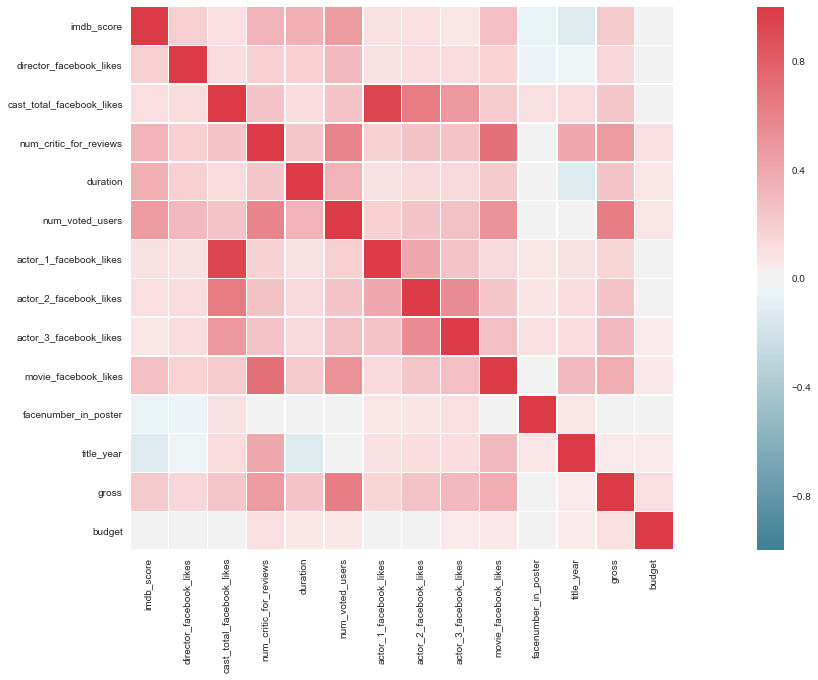

In [231]:
sns.set(style="white")

df_corr= df[['imdb_score','director_facebook_likes','cast_total_facebook_likes','num_critic_for_reviews','duration',
            'num_voted_users','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes','movie_facebook_likes',
            'facenumber_in_poster','title_year','gross', 'budget']]
# Compute the correlation matrix
corr = df_corr.dropna().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, ax=ax)

Choosing 15 continuous variables, I plotted the correlation matrix. Note that "imdb_score" in the matrix denote the IMDB rating score of a movie. The matrix reveals that:

1) The "cast_total_facebook_likes" has a strong positive correlation with the "actor_1_facebook_likes", and has smaller positive correlation with both "actor_2_facebook_likes" and "actor_3_facebook_likes".

2) The "movie_facebook_likes" has strong correlation with "num_critic_for_reviews", meaning that the popularity of a movie in social network can be largely affected by the critics.

3) The "movie_facebook_likes" has relatively large correlation with the "num_voted_users".

4) The movie "gross" has strong positive correlation with the "num_voted_users".

Surprisingly, there are some pairwise correlations that are perhaps counter-intuitive:

1) The "imdb_score" has very small but positive correlation with the "director_facebook_likes", meaning a popular director does not necessarily mean his directed movie is great.

2) The "imdb_score" has very small but positive correlation with the "actor_1_facebook_likes", meaning that an actor is popular in social network does not mean that a movie is high rating if he is the leading actor. So do supporting actors.

3) The "imdb_score" has small but positive correlation with "duration". Long movies tend to have high rating.

4) The "imdb_score" has small but negative correlation with "facenumber_in_poster". It is perhaps not a good idea to have many faces in movie poster if a movie wants to be great.

5) The "imdb_score" has almost no correlation with "budget". Throwing money at a movie will not necessarily make it great.

# Multiple linear regression

Although initially I used 28 variables from IMDB website, many variables are not applicable to predict movie rating. I will therefore only select several critical variables.

Correlation matrix shows that multicollinearity exists in the 15 continuous variables. When fitting a multiple linear regression model to predict movie rating, we need to further remove some variables to reduce multicollinearity.

Therefore, I remove the following variables: "gross", "cast_total_facebook_likes", "num_critic_for_reviews", "num_voted_users", and "movie_facebook_likes".

Some variables are not applicable for prediction, such as "num_voted_users" and "movie_facebook_likes", because these numbers will be unavailable before a movie is released.

In [232]:
df_mlr= df[['imdb_score','director_facebook_likes','duration',
            'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
            'facenumber_in_poster','title_year', 'budget']]

In [233]:
df_mlr = df_mlr.fillna(0)

In [234]:
#score = pd.cut(df_mlr.imdb_score,2, labels=[0,1])
#df_mlr['imdb_score'] = score

In [235]:
# Splitting the dataset into the Training set and Test set

y = df_mlr['imdb_score']
X = df_mlr.iloc[:, 1:9]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [236]:
#Fitting Multiple regression to train Dataset
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
%time regressor.fit(X_train,y_train)

Wall time: 6.09 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [237]:
#predict
%time y_pred = regressor.predict(X_test)

Wall time: 0 ns


In [238]:
# The coefficients
print('Coefficients: \n', regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((y_pred - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
%time print('Variance score: %.2f' % regressor.score(X_test, y_test))

Coefficients: 
 [  4.49174752e-05   1.47341927e-02   3.09395078e-06   2.05900116e-05
  -2.95601861e-05  -3.57401902e-02  -1.01652679e-03   3.62058233e-11]
Mean squared error: 1.12
Variance score: 0.11
Wall time: 0 ns


The "title_year" and "facenumber_in_poster" has negative weight. The "actor_3_facebook_likes" variable was not included in the model at all, meaning that the social network popularity of the third actor in the cast member is not significant to predict the movie rating. This model has multiple R-squared score of 0.17, meaning that around 17% of the variability can be explained by this model.

# Random Forest Regression

A random forest regressor.
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

Random Forest model was fitted to predict movie rating using the following variables:
imdb_score
director_facebook_likes
duration
actor_1_facebook_likes
actor_2_facebook_likes
actor_3_facebook_likes
facenumber_in_poster
budget

The movie dataset was divided into two parts, 2/3 of the movies were treated as the training set, and the rest 1/3 belonged to the testing set. 

Up to 4000 trees were generated to fit the random forest. The number of variables tried at each split of the decision tree is 2. 

The mean of squared residuals is 0.85, and the percentage of variable explained is 33%, better than that of multiple linear regression.

In [239]:
# Fitting Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 4000, random_state = 0)
%time regressor.fit(X_train, y_train)

Wall time: 1min 10s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=4000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [240]:
#predict
%time y_pred = regressor.predict(X_test)

Wall time: 1.78 s


In [241]:

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((y_pred - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regressor.score(X_test, y_test))

Mean squared error: 0.92
Variance score: 0.27


# Support Vector Machine(SVM) Regression

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.

The advantages of support vector machines are:
-----------------------------------------------------
>Effective in high dimensional spaces.
>Still effective in cases where number of dimensions is greater than the number of samples.
>Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
>Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:
-------------------------------------------------------------
If the number of features is much greater than the number of samples, the method is likely to give poor performances.
SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.

In [242]:
# Feature Scaling
#from sklearn.preprocessing import StandardScaler
#sc_X = StandardScaler()
#sc_y = StandardScaler()
#X = sc_X.fit_transform(X)
#y = sc_y.fit_transform(y)

# Fitting SVR to the dataset
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
%time regressor.fit(X_train, y_train)

# Predicting a new result
%time y_pred = regressor.predict(X_test)
#y_pred = sc_y.inverse_transform(y_pred)

Wall time: 1.15 s
Wall time: 359 ms


In [243]:

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((y_pred - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regressor.score(X_test, y_test))

Mean squared error: 1.22
Variance score: 0.02


# Regression Model Cross Validation

In [244]:
# Load the CSV file to a Pandas Dataframe

df=pd.read_csv("movie_metadata.csv")

#Getting non object elements

X_data=df.dtypes[df.dtypes!='object'].index
X_train=df[X_data]

# Filling all Null values
X = X_train.fillna(0)
y=X['imdb_score']
X.drop(['imdb_score'],axis=1,inplace=True)

X  = X.values
y  = y.values

#Defining a function for cross validation, plot and CV Score.
'''
The right way to cross-validate To prevent overfitting, we can't let any information about 
the full dataset leak into cross-validation. Thus, we must re-select good features in each 
cross-validation iteration. '''

def cv_score(model):
    scores = []

    for train, test in KFold(len(y), n_folds=5):      #K-Fold cross validation
        xtrain, xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
    
        b = SelectKBest(f_regression, k=10)   #Selecting 10 best features
        b.fit(xtrain, ytrain)
        xtrain = xtrain[:, b.get_support()]
        xtest = xtest[:, b.get_support()]
    
        model.fit(xtrain, ytrain)    
        scores.append(model.score(xtest, ytest))

        yp = model.predict(xtest)
        plt.plot(yp, ytest, 'o')
        plt.plot(ytest, ytest, 'r-')
    
        plt.xlabel("Predicted")
        plt.ylabel("Observed")
        #np.mean(scores)

        print("CV Score is ", np.mean(scores))

In [245]:
from sklearn import neighbors
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import cross_val_score, KFold

lgr = LinearRegression()                                            #Multiple Linear regressor
rfr = RandomForestRegressor(n_estimators = 4000, random_state = 0)  #Random Forest Regressor
#svr = SVR(kernel = 'rbf')                                          #Support Vector Regressor
rr  = linear_model.Ridge()                                          #Ridge Regressor
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')    #KNN Regressor
reg = linear_model.BayesianRidge()                                  #bayesianRidge


CV Score is  0.249166319989
CV Score is  0.294467196885
CV Score is  0.298621712188
CV Score is  0.28436033477
CV Score is  0.239480965405


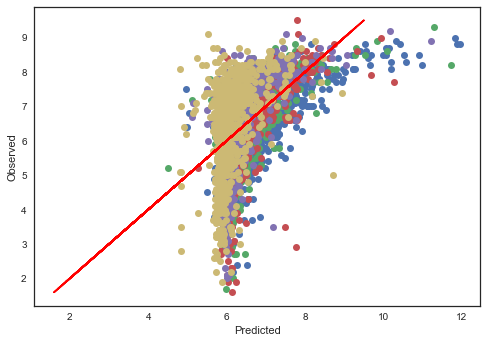

In [246]:
#Multiple Linear Regression Accuracy is 24% with cross validation
cv_score(lgr)

CV Score is  0.383992551367
CV Score is  0.460235022524
CV Score is  0.470703963045
CV Score is  0.461190309165
CV Score is  0.424855047867


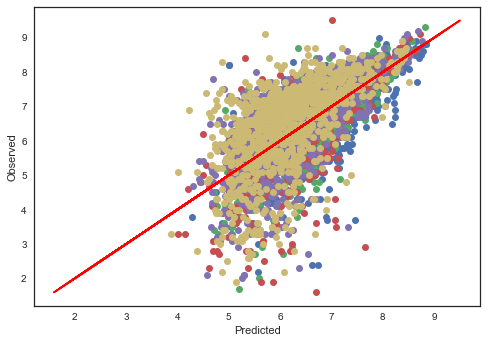

In [247]:
#Random Forest Regression Accuracy is 47% with cross validation
cv_score(rfr)

CV Score is  0.249166168675
CV Score is  0.29446712063
CV Score is  0.298621732631
CV Score is  0.284360347001
CV Score is  0.239481118507


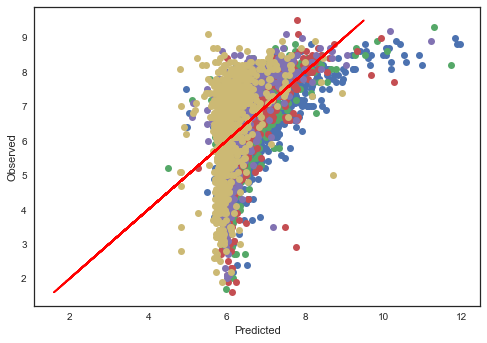

In [248]:
#Ridge Regression Accuracy is 30% with cross validation
cv_score(rr)

CV Score is  0.0408604173756
CV Score is  0.0440103285967
CV Score is  0.053957507882
CV Score is  0.0454220821645
CV Score is  0.0453074426498


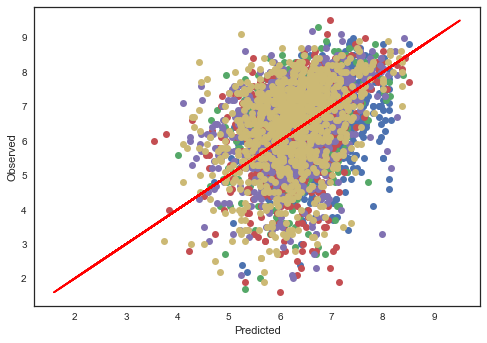

In [249]:
#KNN Regression Accuracy is 5% with cross validation
cv_score(knn)

CV Score is  0.383992551367
CV Score is  0.460235022524
CV Score is  0.470703963045
CV Score is  0.461190309165
CV Score is  0.424855047867


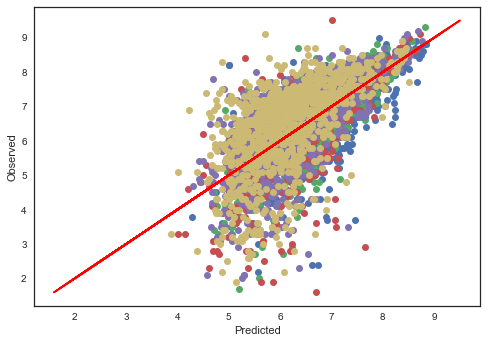

In [250]:
#Bayesian Ridge Regression Accuracy is 47% with cross validation
cv_score(rfr)

# Comparison Table for different Regression Models

In [251]:
%%html
<style>
table {float:left}
</style>

Model|Time_Fit | Time_predict | Accuracy | Accuracy with CV
:------------- |:-------------:| :-----:|:----------:|:--------------:
Multiple Linear Regression | 15.6ms| 255ms| 17%|30% with K=3
Random Forest Regression| 52.7s| 1.45s| 33%|47% with K=3
Ridge Regression|871ms|232ms|2%|30% with K=3
KNN Regression|871ms|232ms|2%|5% with K=3
Bayesian regression|871ms|232ms|33%|47% with K=3


# Insights from regression models


Regression model can predict the actual imdb_score with less than 50% accuracy based on certain predictors say 'director_facebook_likes','duration',
            'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
            'facenumber_in_poster','title_year', 'budget'.


Since the fitted Random Forest/Bayesian model explains more variability than that of multiple linear regression, I will use the results from Random Forest/Bayesian to explain the insights found so far:

The most important factor that affects movie rating is the duration. The longer the movie is, the higher the rating will be.

Budget is important, although there is no strong correlation between budget and movie rating.

The facebook popularity of director is an important factor to affect a movie rating.

The facebook popularity of the top 3 actors/actresses is important.

The number of faces in movie poster has a non-neglectable effect to the movie rating.

# Discretize IMDB_Score to apply qualitative Models

The Pandas cut function can be useful for going from a continuous variable to a categorical variable. Here Pandas cut could convert IMDB_Score to groups of Score ranges.

Any NA values will be NA in the result. Out of bounds values will be NA in the resulting Categorical object.

[7.375, 9.3]   --> Excellent(4)
[5.45, 7.375]  --> Good(3)
[3.525, 5.45]  --> Medium(2)
[1.592, 3.525] --> Bad(1)



In [252]:
#score = pd.cut(df_mlr.imdb_score.sort_values(), 4, labels=['bad','medium','good','excellent'])
score = pd.cut(df_mlr.imdb_score.sort_values(), 2, labels=['bad','good'])

In [253]:
df_mlr['imdb_score'] = score

In [254]:
df_mlr.head()

,imdb_score,director_facebook_likes,duration,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,facenumber_in_poster,title_year,budget
0,good,0.0,178.0,1000.0,936.0,855.0,0.0,2009.0,237000000.0
1,good,563.0,169.0,40000.0,5000.0,1000.0,0.0,2007.0,300000000.0
2,good,0.0,148.0,11000.0,393.0,161.0,1.0,2015.0,245000000.0
3,good,22000.0,164.0,27000.0,23000.0,23000.0,0.0,2012.0,250000000.0
4,good,131.0,0.0,131.0,12.0,0.0,0.0,0.0,0.0


# Decision Tree Classification

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Decision trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.


In [255]:
from sklearn import tree

In [256]:
# Splitting the dataset into the Training set and Test set

y = df_mlr['imdb_score']
X = df_mlr.iloc[:, 1:9]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

y_test.shape

(1681,)

In [257]:
#Fitting DT to the dataset with criterion gini index

clf_gini = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
%time clf_gini.fit(X_train, y_train)

Wall time: 15.6 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

In [258]:
#Fitting DT to the dataset with criterion entropy
clf_entropy = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=3, min_samples_leaf=5)
%time clf_entropy.fit(X_train, y_train)

Wall time: 31.3 ms


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=100, splitter='best')

we have Python module pydotplus installed, we can generate a PDF file (or any other supported file type) directly in Python:

In [259]:
# Predicting the Test set results
%time y_pred_gini = clf_gini.predict(X_test)
%time y_pred_entr = clf_entropy.predict(X_test)

Wall time: 0 ns
Wall time: 0 ns


In [260]:
# Explained variance score: 1 is perfect prediction
%time print('Variance score: %.2f' % clf_gini.score(X_test, y_test))
%time print('Variance score: %.2f' % clf_entropy.score(X_test, y_test))

Variance score: 0.81
Wall time: 0 ns
Variance score: 0.81
Wall time: 0 ns


In [261]:
#Confusion Matrix
# Accuracy rates = correct/total = 1237/1505 = 82%
#Error Rates = wrong/total = 268/1505 = 18%

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_gini)
cm

array([[   0,  311],
       [   0, 1370]])

# Random Forest Classification

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [262]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
%time classifier.fit(X_train, y_train)

Wall time: 119 ms


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [263]:
# Predicting the Test set results
%time y_pred = classifier.predict(X_test)

Wall time: 31.2 ms


In [264]:
# Explained variance score: 1 is perfect prediction
%time print('Variance score: %.2f' % classifier.score(X_test, y_test))

Variance score: 0.80
Wall time: 31.2 ms


In [265]:
#Confusion Matrix
# Accuracy rates = correct/total = 1237/1505 = 82%
#Error Rates = wrong/total = 268/1505 = 18%

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_gini)
cm

array([[   0,  311],
       [   0, 1370]])

# Logistic Regression

In [291]:
df_lgr= df[['imdb_score','director_facebook_likes','duration',
            'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
            'facenumber_in_poster','title_year', 'budget']]

In [292]:
#Dropping all NAN value rows.
df_lgr=df_lgr.dropna()
df_lgr.shape

(4513, 9)

In [293]:
#IMDB_score is divided into 0)bad movies) and 1(good movies) part.
score = pd.cut(df_lgr.imdb_score.sort_values(), 2, labels=['Bad','Good'])
df_lgr['imdb_score'] = score

In [294]:
# Splitting the dataset into the Training set and Test set

y = df_lgr['imdb_score']
X = df_lgr.iloc[:, 1:9]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

y_train.shape

(3008,)

In [295]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

In [296]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C=1000,random_state = 0)
%time classifier.fit(X_train, y_train)

Wall time: 15.6 ms


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [297]:
# Predicting the Test set results
%time y_pred = classifier.predict(X_test)

Wall time: 0 ns


In [299]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[   1,  256],
       [   1, 1247]])

In [300]:
# Explained variance score: 1 is perfect prediction
%time print('Variance score: %.2f' % classifier.score(X_test, y_test))

Variance score: 0.83
Wall time: 19.1 ms


# Comparison Matrix for all Classification models used

In [275]:
%%html
<style>
table {float:left}
</style>

Model|Time_Fit | Time_predict | Accuracy 
:------------- |:-------------:| :-----:|:----------:
Decision Tree Classifier|15.6ms|0ms|82%
Random Forest Classifier|69.4ms|17.1ms|81%
Logistic Regression|15.6ms|0ns|83%




# Classification Insights

After discretizing the imdb_score to two categories Bad (0 to 7.5) and good(7.6 to 10) and fit to different classification models say Decision Tree, RandomForest and Logistic Regression, i am getting 82% of average model prediction accuracy with 18% error prediction rate for the test. That's good actually.

Whereas with original IMDB_score, different regression models can predict only with 47% accuracy.

In order to test if a classification score is significative a technique in repeating the classification procedure after randomizing, permuting, the labels. The p-value is then given by the percentage of runs for which the score obtained is greater than the classification score obtained in the first place.

In [305]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def cv_optimize(clf, parameters, X_train, y_train, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X_train, y_train)
    print ("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best


def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print ("Accuracy on training data: %0.2f" % (training_accuracy))
    print ("Accuracy on test data:     %0.2f" % (test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest



In [302]:
df_lgr.head()

,imdb_score,director_facebook_likes,duration,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,facenumber_in_poster,title_year,budget
0,Good,0.0,178.0,1000.0,936.0,855.0,0.0,2009.0,237000000.0
1,Good,563.0,169.0,40000.0,5000.0,1000.0,0.0,2007.0,300000000.0
2,Good,0.0,148.0,11000.0,393.0,161.0,1.0,2015.0,245000000.0
3,Good,22000.0,164.0,27000.0,23000.0,23000.0,0.0,2012.0,250000000.0
5,Good,475.0,132.0,640.0,632.0,530.0,1.0,2012.0,263700000.0


In [306]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), {"C": [0.01, 0.1, 1, 10, 100]}, 
df_lgr, ['director_facebook_likes','duration','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes','facenumber_in_poster','title_year', 'budget'], 'imdb_score','Good')

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.83
Accuracy on test data:     0.82


In [310]:
Xtest_l

array([[  1.32000000e+02,   8.60000000e+01,   7.78000000e+02, ...,
          2.00000000e+00,   1.99600000e+03,   1.00000000e+06],
       [  3.80000000e+01,   1.01000000e+02,   2.30000000e+04, ...,
          0.00000000e+00,   2.00200000e+03,   6.00000000e+07],
       [  1.90000000e+02,   8.80000000e+01,   1.37000000e+05, ...,
          6.00000000e+00,   2.00900000e+03,   2.70000000e+07],
       ..., 
       [  5.00000000e+00,   8.90000000e+01,   1.10000000e+04, ...,
          0.00000000e+00,   2.01600000e+03,   1.90000000e+07],
       [  2.90000000e+01,   9.10000000e+01,   2.00000000e+03, ...,
          1.00000000e+00,   1.99600000e+03,   4.50000000e+07],
       [  4.70000000e+01,   8.90000000e+01,   6.28000000e+02, ...,
          6.00000000e+00,   2.01500000e+03,   1.90000000e+06]])

In [282]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [283]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

AttributeError: 'int' object has no attribute 'predict'

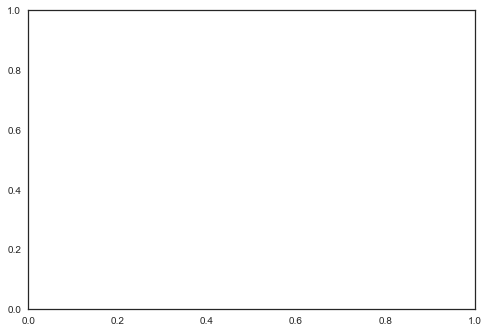

In [312]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, 3, alpha=0.5, psize=20)